In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [77]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa_ = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa_[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa_ / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [75]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [78]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [79]:
cl_orig = target_df.iloc[:,4].values # Cd values

In [80]:
cl = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [81]:
y = cl.reshape((-1,1))

In [82]:
y.shape

(144, 1)

In [83]:
x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [84]:
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [85]:
x_train.shape

(100, 113)

In [86]:
y_train.shape

(100, 1)

In [35]:
tf.keras.backend.set_image_data_format('channels_last')

In [36]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 1)                 129   

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [39]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [40]:
ckpt_name = model_directory + "\\20221130steadyValidation_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_ClOptimalSettings_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [41]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [42]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 5s - loss: 0.3085 - rmse: 0.5554
Epoch 1: val_loss improved from inf to 0.38847, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 2s 56ms/step - loss: 0.3961 - rmse: 0.6294 - val_loss: 0.3885 - val_rmse: 0.6233 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.4761 - rmse: 0.6900
Epoch 2: val_loss improved from 0.38847 to 0.34462, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 23ms/step - loss: 0.3527 - rmse: 0.5939 - val_loss: 0.3446 - val_rmse: 0.5870 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.2918 - rmse: 0.5402
Epoch 3: val_loss improved from 0.34462 to 0.29810, saving model to D:\TrainedModels\20221130\202

1/5 [=====>........................] - ETA: 0s - loss: 0.0135 - rmse: 0.1163
Epoch 21: val_loss improved from 0.01421 to 0.01287, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 22ms/step - loss: 0.0166 - rmse: 0.1288 - val_loss: 0.0129 - val_rmse: 0.1135 - lr: 1.0000e-04
Epoch 22/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0116 - rmse: 0.1079
Epoch 22: val_loss improved from 0.01287 to 0.01203, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 24ms/step - loss: 0.0149 - rmse: 0.1222 - val_loss: 0.0120 - val_rmse: 0.1097 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0991
Epoch 23: val_loss improved from 0.01203 to 0.01170, saving model to D:\TrainedModels\20221130\20221130

5/5 [==============================] - 0s 24ms/step - loss: 0.0085 - rmse: 0.0923 - val_loss: 0.0086 - val_rmse: 0.0929 - lr: 1.0000e-04
Epoch 44/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0063 - rmse: 0.0797
Epoch 44: val_loss did not improve from 0.00863
5/5 [==============================] - 0s 12ms/step - loss: 0.0085 - rmse: 0.0920 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0609
Epoch 45: val_loss improved from 0.00863 to 0.00850, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 23ms/step - loss: 0.0084 - rmse: 0.0916 - val_loss: 0.0085 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 46/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 46: val_loss improved from 0.00850 to 0.00840, saving model to D:\TrainedModel

5/5 [==============================] - 0s 23ms/step - loss: 0.0073 - rmse: 0.0853 - val_loss: 0.0063 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 68/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0101 - rmse: 0.1003
Epoch 68: val_loss did not improve from 0.00629
5/5 [==============================] - 0s 11ms/step - loss: 0.0072 - rmse: 0.0848 - val_loss: 0.0064 - val_rmse: 0.0803 - lr: 1.0000e-04
Epoch 69/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0046 - rmse: 0.0679
Epoch 69: val_loss improved from 0.00629 to 0.00628, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 0.0071 - rmse: 0.0844 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 70/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 70: val_loss improved from 0.00628 to 0.00623, saving model to D:\TrainedModel

5/5 [==============================] - 0s 25ms/step - loss: 0.0062 - rmse: 0.0790 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 92/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0436
Epoch 92: val_loss improved from 0.00518 to 0.00513, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 24ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0051 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 93/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0667
Epoch 93: val_loss did not improve from 0.00513
5/5 [==============================] - 0s 11ms/step - loss: 0.0064 - rmse: 0.0802 - val_loss: 0.0058 - val_rmse: 0.0760 - lr: 1.0000e-04
Epoch 94/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - rmse: 0.0824
Epoch 94: val_loss improved from 0.00513 to 0.00510, saving model to D:\TrainedModel

Epoch 117/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0058 - rmse: 0.0761
Epoch 117: val_loss did not improve from 0.00449
5/5 [==============================] - 0s 12ms/step - loss: 0.0054 - rmse: 0.0735 - val_loss: 0.0048 - val_rmse: 0.0696 - lr: 1.0000e-04
Epoch 118/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0991
Epoch 118: val_loss did not improve from 0.00449
5/5 [==============================] - 0s 11ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 119/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0425
Epoch 119: val_loss improved from 0.00449 to 0.00439, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 46ms/step - loss: 0.0054 - rmse: 0.0738 - val_loss: 0.0044 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 120/10000
1/5 [=====>...

5/5 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0684 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 142/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 142: val_loss did not improve from 0.00378
5/5 [==============================] - 0s 11ms/step - loss: 0.0045 - rmse: 0.0669 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 143/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0569
Epoch 143: val_loss did not improve from 0.00378
5/5 [==============================] - 0s 12ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0038 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 144/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0437
Epoch 144: val_loss improved from 0.00378 to 0.00378, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [=========================

5/5 [==============================] - 0s 25ms/step - loss: 0.0038 - rmse: 0.0618 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-04
Epoch 166/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0850
Epoch 166: val_loss did not improve from 0.00326
5/5 [==============================] - 0s 12ms/step - loss: 0.0035 - rmse: 0.0592 - val_loss: 0.0034 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 167/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0510
Epoch 167: val_loss improved from 0.00326 to 0.00321, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0032 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 168/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0430
Epoch 168: val_loss improved from 0.00321 to 0.00318, saving model to D:\Traine

Epoch 191/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0569
Epoch 191: val_loss improved from 0.00278 to 0.00270, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 0.0028 - rmse: 0.0529 - val_loss: 0.0027 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 192/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0482
Epoch 192: val_loss did not improve from 0.00270
5/5 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0511 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 193/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0470
Epoch 193: val_loss did not improve from 0.00270
5/5 [==============================] - 0s 12ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0027 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 194/10000
1/5 [=====>...

Epoch 214/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0417
Epoch 214: val_loss improved from 0.00220 to 0.00214, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0021 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 215/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0663
Epoch 215: val_loss did not improve from 0.00214
5/5 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0459 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 216/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0512
Epoch 216: val_loss improved from 0.00214 to 0.00210, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [=============================

Epoch 236/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5188e-04 - rmse: 0.0235
Epoch 236: val_loss did not improve from 0.00165
5/5 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0375 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 237/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6554e-04 - rmse: 0.0191
Epoch 237: val_loss improved from 0.00165 to 0.00155, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 0.0014 - rmse: 0.0378 - val_loss: 0.0015 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 238/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6101e-04 - rmse: 0.0257
Epoch 238: val_loss did not improve from 0.00155
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0362 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 239/10000
1/

Epoch 259/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9201e-04 - rmse: 0.0243
Epoch 259: val_loss did not improve from 0.00114
5/5 [==============================] - 0s 12ms/step - loss: 8.4409e-04 - rmse: 0.0291 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 260/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0775e-04 - rmse: 0.0202
Epoch 260: val_loss improved from 0.00114 to 0.00113, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 8.5301e-04 - rmse: 0.0292 - val_loss: 0.0011 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 261/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3146e-04 - rmse: 0.0208
Epoch 261: val_loss improved from 0.00113 to 0.00107, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [=========

5/5 [==============================] - 0s 26ms/step - loss: 5.6639e-04 - rmse: 0.0238 - val_loss: 7.8941e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 282/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 282: val_loss did not improve from 0.00079
5/5 [==============================] - 0s 12ms/step - loss: 5.4486e-04 - rmse: 0.0233 - val_loss: 8.0510e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 283/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2578e-04 - rmse: 0.0180
Epoch 283: val_loss improved from 0.00079 to 0.00077, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 5.2781e-04 - rmse: 0.0230 - val_loss: 7.6591e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 284/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2112e-04 - rmse: 0.0179
Epoch 284: val_loss improved from 0.00077 to 0.

5/5 [==============================] - 0s 25ms/step - loss: 3.1686e-04 - rmse: 0.0178 - val_loss: 5.6629e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 307/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3624e-04 - rmse: 0.0154
Epoch 307: val_loss did not improve from 0.00057
5/5 [==============================] - 0s 12ms/step - loss: 3.6276e-04 - rmse: 0.0190 - val_loss: 5.6675e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 308/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5766e-04 - rmse: 0.0126
Epoch 308: val_loss improved from 0.00057 to 0.00055, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 3.3409e-04 - rmse: 0.0183 - val_loss: 5.5086e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 309/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9724e-05 - rmse: 0.0095
Epoch 309: val_loss did not improve from 0.

Epoch 329/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6337e-04 - rmse: 0.0162
Epoch 329: val_loss did not improve from 0.00043
5/5 [==============================] - 0s 12ms/step - loss: 2.0880e-04 - rmse: 0.0144 - val_loss: 4.3914e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 330/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.2528e-05 - rmse: 0.0091
Epoch 330: val_loss improved from 0.00043 to 0.00042, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 1.8463e-04 - rmse: 0.0136 - val_loss: 4.2357e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 331/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5622e-04 - rmse: 0.0125
Epoch 331: val_loss improved from 0.00042 to 0.00041, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [=

1/5 [=====>........................] - ETA: 0s - loss: 1.5481e-04 - rmse: 0.0124
Epoch 353: val_loss did not improve from 0.00037
5/5 [==============================] - 0s 12ms/step - loss: 1.8854e-04 - rmse: 0.0137 - val_loss: 4.8505e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 354/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8940e-04 - rmse: 0.0138
Epoch 354: val_loss did not improve from 0.00037
5/5 [==============================] - 0s 11ms/step - loss: 1.8576e-04 - rmse: 0.0136 - val_loss: 4.3342e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 355/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3519e-04 - rmse: 0.0153
Epoch 355: val_loss improved from 0.00037 to 0.00036, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 1.8717e-04 - rmse: 0.0137 - val_loss: 3.6465e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 356/

1/5 [=====>........................] - ETA: 0s - loss: 5.5556e-05 - rmse: 0.0075
Epoch 377: val_loss improved from 0.00028 to 0.00027, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 8.4663e-05 - rmse: 0.0092 - val_loss: 2.6849e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 378/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2751e-04 - rmse: 0.0113
Epoch 378: val_loss did not improve from 0.00027
5/5 [==============================] - 0s 12ms/step - loss: 8.8632e-05 - rmse: 0.0094 - val_loss: 2.8703e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 379/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5550e-05 - rmse: 0.0098
Epoch 379: val_loss did not improve from 0.00027
5/5 [==============================] - 0s 12ms/step - loss: 9.2414e-05 - rmse: 0.0096 - val_loss: 2.9869e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 380/

1/5 [=====>........................] - ETA: 0s - loss: 2.9805e-05 - rmse: 0.0055
Epoch 401: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 11ms/step - loss: 6.3921e-05 - rmse: 0.0080 - val_loss: 2.2962e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 402/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2455e-05 - rmse: 0.0065
Epoch 402: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 12ms/step - loss: 6.2255e-05 - rmse: 0.0079 - val_loss: 2.2980e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 403/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0329e-05 - rmse: 0.0064
Epoch 403: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 12ms/step - loss: 5.8740e-05 - rmse: 0.0077 - val_loss: 2.3368e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 404/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7986e-05 - rmse: 0.0069
Epoch 404: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 6.5696e-05 - rmse: 0.0081
Epoch 425: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 12ms/step - loss: 4.7807e-05 - rmse: 0.0069 - val_loss: 1.9898e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 426/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0901e-05 - rmse: 0.0056
Epoch 426: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 12ms/step - loss: 5.2170e-05 - rmse: 0.0072 - val_loss: 2.0933e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 427/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1988e-05 - rmse: 0.0065
Epoch 427: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 12ms/step - loss: 5.5223e-05 - rmse: 0.0074 - val_loss: 2.0398e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 428/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5000e-05 - rmse: 0.0050
Epoch 428: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 2.9323e-05 - rmse: 0.0054
Epoch 450: val_loss improved from 0.00017 to 0.00016, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 4.3040e-05 - rmse: 0.0066 - val_loss: 1.6343e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 451/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4846e-05 - rmse: 0.0059
Epoch 451: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 3.1171e-05 - rmse: 0.0056 - val_loss: 1.5930e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 452/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6979e-05 - rmse: 0.0052
Epoch 452: val_loss did not improve from 0.00016
5/5 [=================

Epoch 477/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0617e-05 - rmse: 0.0045
Epoch 477: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 2.1937e-05 - rmse: 0.0047 - val_loss: 1.5307e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 478/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9588e-05 - rmse: 0.0054
Epoch 478: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 12ms/step - loss: 2.0314e-05 - rmse: 0.0045 - val_loss: 1.5549e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 479/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7054e-05 - rmse: 0.0041
Epoch 479: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [=

Epoch 503/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6467e-06 - rmse: 0.0029
Epoch 503: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 12ms/step - loss: 1.5744e-05 - rmse: 0.0040 - val_loss: 1.5301e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 504/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9115e-06 - rmse: 0.0022
Epoch 504: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 12ms/step - loss: 1.7872e-05 - rmse: 0.0042 - val_loss: 1.5610e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 505/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0761e-05 - rmse: 0.0033
Epoch 505: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 11ms/step - loss: 1.5144e-05 - rmse: 0.0039 - val_loss: 1.5080e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 506/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1274e-06 - rmse: 0.0030
Epoch 506: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 5.4634e-06 - rmse: 0.0023
Epoch 530: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.2303e-05 - rmse: 0.0035 - val_loss: 1.5792e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 531/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5083e-05 - rmse: 0.0039
Epoch 531: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.4870e-05 - rmse: 0.0039 - val_loss: 1.4735e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 532/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3864e-06 - rmse: 0.0029
Epoch 532: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 1.2012e-05 - rmse: 0.0035 - val_loss: 1.5445e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 533/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2500e-05 - rmse: 0.0047
Epoch 533: val_loss improved from 0.00014 to 0

5/5 [==============================] - 0s 22ms/step - loss: 1.0026e-05 - rmse: 0.0032 - val_loss: 1.3226e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 557/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6984e-05 - rmse: 0.0041
Epoch 557: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 9.1524e-06 - rmse: 0.0030 - val_loss: 1.3750e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 558/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8979e-06 - rmse: 0.0026
Epoch 558: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 7.4487e-06 - rmse: 0.0027 - val_loss: 1.3993e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 559/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3817e-06 - rmse: 0.0027
Epoch 559: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 9.2457e-06 - rmse: 0.0030 - val_loss: 1.3963e-04 - val_rmse: 0.0118

1/5 [=====>........................] - ETA: 0s - loss: 1.6072e-05 - rmse: 0.0040
Epoch 584: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 1.1785e-05 - rmse: 0.0034 - val_loss: 1.5060e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 585/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1956e-05 - rmse: 0.0035
Epoch 585: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 1.0013e-05 - rmse: 0.0032 - val_loss: 1.4565e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 586/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9429e-05 - rmse: 0.0044
Epoch 586: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 1.2497e-05 - rmse: 0.0035 - val_loss: 1.3761e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 587/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1378e-05 - rmse: 0.0034
Epoch 587: val_loss improved from 0.00013 to 0

Epoch 611/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7078e-06 - rmse: 0.0024
Epoch 611: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 3.8699e-06 - rmse: 0.0020 - val_loss: 1.3076e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 612/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5551e-06 - rmse: 0.0021
Epoch 612: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 4.0383e-06 - rmse: 0.0020 - val_loss: 1.3347e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 613/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0350e-06 - rmse: 0.0025
Epoch 613: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 12ms/step - loss: 4.2454e-06 - rmse: 0.0021 - val_loss: 1.2980e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 614/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2496e-06 - rmse: 0.0018
Epoch 614: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 3.1465e-06 - rmse: 0.0018
Epoch 637: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 2.6764e-06 - rmse: 0.0016 - val_loss: 1.3282e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 638/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9671e-06 - rmse: 0.0014
Epoch 638: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 4.0908e-06 - rmse: 0.0020 - val_loss: 1.3453e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 639/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0085e-06 - rmse: 0.0022
Epoch 639: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 3.8294e-06 - rmse: 0.0020 - val_loss: 1.2937e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 640/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9422e-06 - rmse: 0.0014
Epoch 640: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.3271e-06 - rmse: 0.0012
Epoch 665: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 2.4399e-06 - rmse: 0.0016 - val_loss: 1.2482e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 666/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8082e-06 - rmse: 0.0013
Epoch 666: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 2.1418e-06 - rmse: 0.0015 - val_loss: 1.2501e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 667/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9991e-06 - rmse: 0.0014
Epoch 667: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.8687e-06 - rmse: 0.0014 - val_loss: 1.2306e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 668/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3368e-06 - rmse: 0.0015
Epoch 668: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.1467e-06 - rmse: 0.0011
Epoch 693: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.6443e-06 - rmse: 0.0013 - val_loss: 1.2301e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 694/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7813e-06 - rmse: 0.0013
Epoch 694: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.6019e-06 - rmse: 0.0013 - val_loss: 1.2209e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 695/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7910e-06 - rmse: 0.0013
Epoch 695: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.8079e-06 - rmse: 0.0013 - val_loss: 1.2244e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 696/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1961e-06 - rmse: 0.0011
Epoch 696: val_loss did not improve from 0.000

Epoch 720/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5731e-06 - rmse: 0.0013
Epoch 720: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.2976e-06 - rmse: 0.0011 - val_loss: 1.1977e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 721/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6961e-06 - rmse: 0.0013
Epoch 721: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.2523e-06 - rmse: 0.0011 - val_loss: 1.2084e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 722/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0239e-06 - rmse: 0.0017
Epoch 722: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 1.9546e-06 - rmse: 0.0014 - val_loss: 1.2240e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 723/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7005e-06 - rmse: 0.0019
Epoch 723: val_loss did not im

Epoch 748/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7182e-06 - rmse: 0.0013
Epoch 748: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 2.1741e-06 - rmse: 0.0015 - val_loss: 1.1855e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 749/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.0611e-07 - rmse: 9.5190e-04
Epoch 749: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 12ms/step - loss: 2.0721e-06 - rmse: 0.0014 - val_loss: 1.1906e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 750/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.0773e-07 - rmse: 9.5275e-04
Epoch 750: val_loss improved from 0.00012 to 0.00011, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 23ms/step - loss: 2.1785e-06 - rmse: 0.0015 - val_loss: 1.1307e-04 - val_rmse: 0.0106 - l

1/5 [=====>........................] - ETA: 0s - loss: 1.8266e-06 - rmse: 0.0014
Epoch 775: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.3306e-06 - rmse: 0.0012 - val_loss: 1.1571e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 776/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8191e-06 - rmse: 0.0013
Epoch 776: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.0772e-06 - rmse: 0.0010 - val_loss: 1.1950e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 777/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2375e-06 - rmse: 0.0011
Epoch 777: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 13ms/step - loss: 1.1817e-06 - rmse: 0.0011 - val_loss: 1.2099e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 778/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3307e-07 - rmse: 8.5620e-04
Epoch 778: val_loss did not improve from 0

Epoch 803/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5700e-06 - rmse: 0.0016
Epoch 803: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 2.3209e-06 - rmse: 0.0015 - val_loss: 1.2145e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 804/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9019e-06 - rmse: 0.0014
Epoch 804: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 11ms/step - loss: 1.2561e-06 - rmse: 0.0011 - val_loss: 1.1841e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 805/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5633e-06 - rmse: 0.0013
Epoch 805: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.1932e-06 - rmse: 0.0011 - val_loss: 1.1427e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 806/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0699e-07 - rmse: 8.4083e-04
Epoch 806: val_loss did no

5/5 [==============================] - 0s 12ms/step - loss: 1.2859e-06 - rmse: 0.0011 - val_loss: 1.1338e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 831/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1864e-07 - rmse: 9.0479e-04
Epoch 831: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 2.0401e-06 - rmse: 0.0014 - val_loss: 1.1403e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 832/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1143e-06 - rmse: 0.0020
Epoch 832: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 2.8371e-06 - rmse: 0.0017 - val_loss: 1.1262e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 833/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3987e-07 - rmse: 7.9992e-04
Epoch 833: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.4830e-06 - rmse: 0.0012 - val_loss: 1.2056e-04 - val_rmse

1/5 [=====>........................] - ETA: 0s - loss: 1.5457e-06 - rmse: 0.0012
Epoch 858: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.3543e-06 - rmse: 0.0012 - val_loss: 1.1342e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 859/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1674e-07 - rmse: 6.4555e-04
Epoch 859: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 12ms/step - loss: 1.3371e-06 - rmse: 0.0012 - val_loss: 1.0947e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 860/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0493e-06 - rmse: 0.0010
Epoch 860: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 11ms/step - loss: 1.1239e-06 - rmse: 0.0011 - val_loss: 1.1141e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 861/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6508e-07 - rmse: 7.5172e-04
Epoch 861: val_loss did not improve fr

Epoch 886/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0141e-06 - rmse: 0.0014
Epoch 886: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.3413e-06 - rmse: 0.0015 - val_loss: 1.2162e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 887/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7705e-06 - rmse: 0.0017
Epoch 887: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.8445e-06 - rmse: 0.0017 - val_loss: 1.2746e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 888/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4031e-06 - rmse: 0.0016
Epoch 888: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 8.0477e-06 - rmse: 0.0028 - val_loss: 1.3648e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 889/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0753e-05 - rmse: 0.0055
Epoch 889: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 1.5824e-05 - rmse: 0.0040
Epoch 914: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.3124e-05 - rmse: 0.0048 - val_loss: 1.7499e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 915/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5676e-05 - rmse: 0.0068
Epoch 915: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.9419e-05 - rmse: 0.0054 - val_loss: 2.0281e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 916/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3693e-05 - rmse: 0.0086
Epoch 916: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 4.7613e-05 - rmse: 0.0069 - val_loss: 1.0278e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 917/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7567e-06 - rmse: 0.0030
Epoch 917: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 5.5901e-06 - rmse: 0.0024
Epoch 942: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 3.9589e-06 - rmse: 0.0020 - val_loss: 1.2359e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 943/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7222e-06 - rmse: 0.0026
Epoch 943: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 4.0217e-06 - rmse: 0.0020 - val_loss: 1.1512e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 944/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8207e-06 - rmse: 0.0013
Epoch 944: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.2389e-06 - rmse: 0.0015 - val_loss: 1.1033e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 945/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4748e-06 - rmse: 0.0023
Epoch 945: val_loss did not improve from 0.000

Epoch 970/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1439e-06 - rmse: 0.0015
Epoch 970: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 3.2444e-06 - rmse: 0.0018 - val_loss: 1.1047e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 971/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1888e-06 - rmse: 0.0015
Epoch 971: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.0139e-06 - rmse: 0.0014 - val_loss: 1.0534e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 972/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8565e-07 - rmse: 9.9280e-04
Epoch 972: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.0306e-06 - rmse: 0.0014 - val_loss: 1.0755e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 973/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1737e-06 - rmse: 0.0011
Epoch 973: val_loss did no

1/5 [=====>........................] - ETA: 0s - loss: 1.5523e-06 - rmse: 0.0012
Epoch 998: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 11ms/step - loss: 7.4832e-07 - rmse: 8.6505e-04 - val_loss: 1.0754e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 999/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5799e-07 - rmse: 5.9832e-04
Epoch 999: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 4.6503e-07 - rmse: 6.8193e-04 - val_loss: 1.0510e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 1000/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4432e-07 - rmse: 9.7176e-04
Epoch 1000: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 1.0509e-06 - rmse: 0.0010 - val_loss: 1.0751e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 1001/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0009e-07 - rmse: 7.0717e-04
Epoch 1001: val_loss di

Epoch 1026/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5606e-07 - rmse: 7.4569e-04
Epoch 1026: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 1.2964e-06 - rmse: 0.0011 - val_loss: 1.0870e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 1027/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8294e-07 - rmse: 7.6351e-04
Epoch 1027: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 11ms/step - loss: 9.5999e-07 - rmse: 9.7979e-04 - val_loss: 1.1469e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1028/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8467e-07 - rmse: 9.9230e-04
Epoch 1028: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 1.2740e-06 - rmse: 0.0011 - val_loss: 1.1501e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1029/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8206e-06 - rmse: 0.0013
Epoch 1

Epoch 1054/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5254e-05 - rmse: 0.0050
Epoch 1054: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 3.6956e-05 - rmse: 0.0061 - val_loss: 1.5675e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 1055/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0372e-05 - rmse: 0.0055
Epoch 1055: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.9146e-05 - rmse: 0.0054 - val_loss: 1.3688e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1056/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9368e-05 - rmse: 0.0054
Epoch 1056: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 3.6817e-05 - rmse: 0.0061 - val_loss: 1.8151e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 1057/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3636e-05 - rmse: 0.0097
Epoch 1057: val_loss di

Epoch 1082/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3828e-05 - rmse: 0.0080
Epoch 1082: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 4.7046e-05 - rmse: 0.0069 - val_loss: 1.1824e-04 - val_rmse: 0.0109 - lr: 5.0000e-05
Epoch 1083/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8827e-05 - rmse: 0.0043
Epoch 1083: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 2.3339e-05 - rmse: 0.0048 - val_loss: 1.2661e-04 - val_rmse: 0.0113 - lr: 5.0000e-05
Epoch 1084/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5351e-05 - rmse: 0.0039
Epoch 1084: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 3.5525e-05 - rmse: 0.0060 - val_loss: 1.4881e-04 - val_rmse: 0.0122 - lr: 5.0000e-05
Epoch 1085/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2490e-05 - rmse: 0.0057
Epoch 1085: val_loss di

5/5 [==============================] - 0s 12ms/step - loss: 1.0953e-06 - rmse: 0.0010 - val_loss: 9.8967e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1110/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4078e-07 - rmse: 9.1694e-04
Epoch 1110: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 1.0787e-06 - rmse: 0.0010 - val_loss: 9.9299e-05 - val_rmse: 0.0100 - lr: 5.0000e-05
Epoch 1111/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3846e-07 - rmse: 7.9904e-04
Epoch 1111: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 1.1514e-06 - rmse: 0.0011 - val_loss: 9.9536e-05 - val_rmse: 0.0100 - lr: 5.0000e-05
Epoch 1112/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4004e-06 - rmse: 0.0012
Epoch 1112: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221130\20221130steadyValidation_MLP_val_0.2_test0.1_128units_ClOptimalSet

5/5 [==============================] - 0s 23ms/step - loss: 6.7615e-07 - rmse: 8.2228e-04 - val_loss: 9.6132e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1136/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5960e-07 - rmse: 5.0951e-04
Epoch 1136: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 6.9103e-07 - rmse: 8.3128e-04 - val_loss: 9.7029e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1137/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5333e-07 - rmse: 8.6794e-04
Epoch 1137: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 6.6509e-07 - rmse: 8.1553e-04 - val_loss: 9.6434e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1138/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3120e-07 - rmse: 7.2884e-04
Epoch 1138: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 12ms/step - loss: 5.2709e-07 - rmse: 7.2601e-04 - val_l

1/5 [=====>........................] - ETA: 0s - loss: 4.4748e-07 - rmse: 6.6894e-04
Epoch 1160: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 4.1209e-07 - rmse: 6.4195e-04 - val_loss: 9.5387e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1161/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0251e-07 - rmse: 4.5001e-04
Epoch 1161: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 3.1101e-07 - rmse: 5.5769e-04 - val_loss: 9.5916e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1162/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1040e-07 - rmse: 5.5714e-04
Epoch 1162: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 4.0850e-07 - rmse: 6.3914e-04 - val_loss: 9.5536e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1163/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6476e-07 - rmse: 5.1455e-04
Epoch 1163: 

Epoch 1186/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0647e-07 - rmse: 4.5439e-04
Epoch 1186: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1191e-07 - rmse: 4.6034e-04 - val_loss: 9.5620e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1187/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9698e-07 - rmse: 4.4382e-04
Epoch 1187: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1336e-07 - rmse: 4.6190e-04 - val_loss: 9.5495e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1188/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5951e-07 - rmse: 3.9938e-04
Epoch 1188: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.5277e-07 - rmse: 5.0276e-04 - val_loss: 9.5355e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1189/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7236e-07 - rmse: 5.2188

1/5 [=====>........................] - ETA: 0s - loss: 1.7427e-07 - rmse: 4.1746e-04
Epoch 1213: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.5680e-07 - rmse: 3.9598e-04 - val_loss: 9.6063e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1214/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6526e-07 - rmse: 4.0652e-04
Epoch 1214: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.4562e-07 - rmse: 3.8160e-04 - val_loss: 9.6206e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1215/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2974e-07 - rmse: 3.6019e-04
Epoch 1215: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.4900e-07 - rmse: 3.8601e-04 - val_loss: 9.5784e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1216/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6767e-08 - rmse: 2.9456e-04
Epoch 1216: 

1/5 [=====>........................] - ETA: 0s - loss: 1.4611e-07 - rmse: 3.8225e-04
Epoch 1240: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.4890e-07 - rmse: 4.9890e-04 - val_loss: 9.6731e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1241/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4676e-07 - rmse: 7.3943e-04
Epoch 1241: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 3.2396e-07 - rmse: 5.6918e-04 - val_loss: 9.5690e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1242/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7468e-07 - rmse: 6.1211e-04
Epoch 1242: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.2791e-07 - rmse: 4.7740e-04 - val_loss: 9.5094e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1243/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0533e-07 - rmse: 3.2454e-04
Epoch 1243: 

1/5 [=====>........................] - ETA: 0s - loss: 6.1650e-08 - rmse: 2.4829e-04
Epoch 1267: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0305e-07 - rmse: 3.2101e-04 - val_loss: 9.6627e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1268/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9898e-08 - rmse: 2.2338e-04
Epoch 1268: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 8.8745e-08 - rmse: 2.9790e-04 - val_loss: 9.6762e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1269/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7655e-08 - rmse: 2.6011e-04
Epoch 1269: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0384e-07 - rmse: 3.2225e-04 - val_loss: 9.6530e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1270/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3884e-07 - rmse: 3.7261e-04
Epoch 1270: 

1/5 [=====>........................] - ETA: 0s - loss: 5.8644e-08 - rmse: 2.4216e-04
Epoch 1294: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.0512e-08 - rmse: 3.0085e-04 - val_loss: 9.7882e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1295/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3457e-08 - rmse: 2.3121e-04
Epoch 1295: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.8670e-08 - rmse: 2.8048e-04 - val_loss: 9.7789e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1296/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4941e-08 - rmse: 2.9145e-04
Epoch 1296: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.6743e-08 - rmse: 2.7703e-04 - val_loss: 9.6944e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1297/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4878e-08 - rmse: 2.9134e-04
Epoch 1297: 

1/5 [=====>........................] - ETA: 0s - loss: 5.3743e-08 - rmse: 2.3183e-04
Epoch 1321: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.7677e-08 - rmse: 2.6015e-04 - val_loss: 9.7172e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1322/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9796e-08 - rmse: 1.9949e-04
Epoch 1322: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.5475e-08 - rmse: 2.9236e-04 - val_loss: 9.7147e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1323/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0174e-08 - rmse: 1.4204e-04
Epoch 1323: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.2651e-08 - rmse: 2.8749e-04 - val_loss: 9.7321e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1324/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8328e-08 - rmse: 2.6140e-04
Epoch 1324: 

1/5 [=====>........................] - ETA: 0s - loss: 1.2021e-07 - rmse: 3.4672e-04
Epoch 1348: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.4179e-07 - rmse: 3.7655e-04 - val_loss: 9.6661e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1349/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0215e-07 - rmse: 3.1961e-04
Epoch 1349: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.5228e-07 - rmse: 3.9024e-04 - val_loss: 9.7438e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1350/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3754e-07 - rmse: 3.7087e-04
Epoch 1350: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.6497e-07 - rmse: 4.0616e-04 - val_loss: 9.7128e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1351/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0802e-07 - rmse: 3.2866e-04
Epoch 1351: 

1/5 [=====>........................] - ETA: 0s - loss: 9.6933e-08 - rmse: 3.1134e-04
Epoch 1375: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 5.5244e-08 - rmse: 2.3504e-04 - val_loss: 9.7074e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1376/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7134e-08 - rmse: 2.3903e-04
Epoch 1376: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.8287e-08 - rmse: 2.6132e-04 - val_loss: 9.6322e-05 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 1377/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7993e-08 - rmse: 2.6075e-04
Epoch 1377: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 5.5710e-08 - rmse: 2.3603e-04 - val_loss: 9.7278e-05 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 1378/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0878e-08 - rmse: 2.0218e-04
Epoch 1378: 

1/5 [=====>........................] - ETA: 0s - loss: 2.2428e-08 - rmse: 1.4976e-04
Epoch 1402: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.2663e-08 - rmse: 1.5054e-04 - val_loss: 9.7382e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1403/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6799e-09 - rmse: 9.3166e-05
Epoch 1403: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.0899e-08 - rmse: 1.4456e-04 - val_loss: 9.7102e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1404/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6128e-09 - rmse: 9.8045e-05
Epoch 1404: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.4872e-08 - rmse: 1.5771e-04 - val_loss: 9.7493e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1405/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3962e-08 - rmse: 1.1816e-04
Epoch 1405: 

1/5 [=====>........................] - ETA: 0s - loss: 2.8831e-08 - rmse: 1.6980e-04
Epoch 1429: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 3.2441e-08 - rmse: 1.8011e-04 - val_loss: 9.7530e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1430/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5584e-08 - rmse: 1.8864e-04
Epoch 1430: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.6732e-08 - rmse: 1.6350e-04 - val_loss: 9.7342e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1431/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3149e-08 - rmse: 1.8207e-04
Epoch 1431: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 2.8308e-08 - rmse: 1.6825e-04 - val_loss: 9.7373e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1432/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0271e-09 - rmse: 8.9594e-05
Epoch 1432: 

1/5 [=====>........................] - ETA: 0s - loss: 1.8366e-08 - rmse: 1.3552e-04
Epoch 1456: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.3986e-08 - rmse: 1.5488e-04 - val_loss: 9.7924e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1457/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7743e-08 - rmse: 1.3320e-04
Epoch 1457: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.2338e-08 - rmse: 1.4946e-04 - val_loss: 9.7648e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1458/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1545e-09 - rmse: 5.6165e-05
Epoch 1458: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.4085e-08 - rmse: 1.5519e-04 - val_loss: 9.7523e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1459/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9091e-08 - rmse: 1.9771e-04
Epoch 1459: 

1/5 [=====>........................] - ETA: 0s - loss: 8.6282e-09 - rmse: 9.2888e-05
Epoch 1483: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.9250e-08 - rmse: 1.3875e-04 - val_loss: 9.7840e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1484/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1976e-08 - rmse: 1.0944e-04
Epoch 1484: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.8256e-08 - rmse: 1.3512e-04 - val_loss: 9.7765e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1485/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7474e-08 - rmse: 1.3219e-04
Epoch 1485: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.8976e-08 - rmse: 1.3775e-04 - val_loss: 9.7832e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1486/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2522e-08 - rmse: 1.1190e-04
Epoch 1486: 

1/5 [=====>........................] - ETA: 0s - loss: 7.4003e-09 - rmse: 8.6025e-05
Epoch 1510: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.6851e-08 - rmse: 1.2981e-04 - val_loss: 9.7893e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1511/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4899e-09 - rmse: 4.9899e-05
Epoch 1511: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1168e-08 - rmse: 1.4549e-04 - val_loss: 9.7985e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1512/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6341e-09 - rmse: 7.5060e-05
Epoch 1512: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.8338e-08 - rmse: 1.3542e-04 - val_loss: 9.8209e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1513/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5680e-08 - rmse: 1.2522e-04
Epoch 1513: 

1/5 [=====>........................] - ETA: 0s - loss: 4.2479e-08 - rmse: 2.0610e-04
Epoch 1537: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 4.5140e-08 - rmse: 2.1246e-04 - val_loss: 9.7814e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1538/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5825e-08 - rmse: 1.6070e-04
Epoch 1538: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 3.0767e-08 - rmse: 1.7541e-04 - val_loss: 9.8076e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1539/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1102e-08 - rmse: 1.7636e-04
Epoch 1539: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 3.2134e-08 - rmse: 1.7926e-04 - val_loss: 9.8509e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1540/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8266e-08 - rmse: 1.6813e-04
Epoch 1540: 

1/5 [=====>........................] - ETA: 0s - loss: 1.9188e-08 - rmse: 1.3852e-04
Epoch 1564: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.7105e-08 - rmse: 1.6463e-04 - val_loss: 9.8176e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1565/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0387e-08 - rmse: 1.0192e-04
Epoch 1565: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1229e-08 - rmse: 1.4570e-04 - val_loss: 9.7771e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1566/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4462e-08 - rmse: 2.1086e-04
Epoch 1566: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1210e-08 - rmse: 1.4564e-04 - val_loss: 9.8232e-05 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 1567/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4968e-08 - rmse: 1.2235e-04
Epoch 1567: 

1/5 [=====>........................] - ETA: 0s - loss: 1.0014e-08 - rmse: 1.0007e-04
Epoch 1591: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.2934e-08 - rmse: 1.1373e-04 - val_loss: 9.8156e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1592/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2490e-09 - rmse: 6.5185e-05
Epoch 1592: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.1621e-08 - rmse: 1.0780e-04 - val_loss: 9.8026e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1593/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4587e-08 - rmse: 1.2078e-04
Epoch 1593: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.1543e-08 - rmse: 1.0744e-04 - val_loss: 9.8347e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1594/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7095e-09 - rmse: 7.5561e-05
Epoch 1594: 

1/5 [=====>........................] - ETA: 0s - loss: 8.5174e-09 - rmse: 9.2290e-05
Epoch 1618: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.3942e-08 - rmse: 1.1808e-04 - val_loss: 9.8596e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1619/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2635e-08 - rmse: 1.1241e-04
Epoch 1619: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.4114e-08 - rmse: 1.1880e-04 - val_loss: 9.8576e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1620/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5443e-08 - rmse: 1.2427e-04
Epoch 1620: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.2678e-08 - rmse: 1.1260e-04 - val_loss: 9.8632e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1621/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1938e-08 - rmse: 1.0926e-04
Epoch 1621: 

1/5 [=====>........................] - ETA: 0s - loss: 1.8949e-08 - rmse: 1.3765e-04
Epoch 1645: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.6263e-08 - rmse: 1.2753e-04 - val_loss: 9.8585e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1646/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1725e-08 - rmse: 1.0828e-04
Epoch 1646: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 1.9650e-08 - rmse: 1.4018e-04 - val_loss: 9.8768e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1647/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9076e-08 - rmse: 1.3812e-04
Epoch 1647: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.3854e-08 - rmse: 1.5445e-04 - val_loss: 9.8327e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1648/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8758e-08 - rmse: 1.9687e-04
Epoch 1648: 

1/5 [=====>........................] - ETA: 0s - loss: 2.5706e-08 - rmse: 1.6033e-04
Epoch 1672: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.0231e-08 - rmse: 1.4224e-04 - val_loss: 9.8198e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1673/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8016e-09 - rmse: 9.3817e-05
Epoch 1673: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.3007e-08 - rmse: 1.1405e-04 - val_loss: 9.7997e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1674/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0789e-08 - rmse: 1.4418e-04
Epoch 1674: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.1221e-08 - rmse: 1.4568e-04 - val_loss: 9.8027e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1675/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0910e-08 - rmse: 1.4460e-04
Epoch 1675: 

1/5 [=====>........................] - ETA: 0s - loss: 1.0369e-08 - rmse: 1.0183e-04
Epoch 1699: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.5543e-08 - rmse: 1.2467e-04 - val_loss: 9.9392e-05 - val_rmse: 0.0100 - lr: 1.2500e-05
Epoch 1700/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6148e-08 - rmse: 1.6170e-04
Epoch 1700: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.5592e-08 - rmse: 1.2487e-04 - val_loss: 9.9526e-05 - val_rmse: 0.0100 - lr: 1.2500e-05
Epoch 1701/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9126e-08 - rmse: 1.9780e-04
Epoch 1701: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.4253e-08 - rmse: 1.5573e-04 - val_loss: 9.8978e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1702/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2725e-08 - rmse: 2.5045e-04
Epoch 1702: 

1/5 [=====>........................] - ETA: 0s - loss: 7.6445e-09 - rmse: 8.7433e-05
Epoch 1726: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.3691e-08 - rmse: 1.1701e-04 - val_loss: 9.8630e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1727/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7980e-08 - rmse: 1.3409e-04
Epoch 1727: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.8302e-08 - rmse: 1.3529e-04 - val_loss: 9.8468e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1728/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3394e-09 - rmse: 7.9621e-05
Epoch 1728: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.4531e-08 - rmse: 1.2054e-04 - val_loss: 9.8881e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1729/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2503e-08 - rmse: 1.1182e-04
Epoch 1729: 

1/5 [=====>........................] - ETA: 0s - loss: 2.8718e-08 - rmse: 1.6946e-04
Epoch 1753: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 2.8456e-08 - rmse: 1.6869e-04 - val_loss: 9.9174e-05 - val_rmse: 0.0100 - lr: 1.2500e-05
Epoch 1754/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0889e-08 - rmse: 2.0221e-04
Epoch 1754: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.6892e-08 - rmse: 1.2997e-04 - val_loss: 9.8834e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1755/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0997e-08 - rmse: 1.0487e-04
Epoch 1755: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.2693e-08 - rmse: 1.1266e-04 - val_loss: 9.8889e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1756/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0287e-09 - rmse: 7.0913e-05
Epoch 1756: 

1/5 [=====>........................] - ETA: 0s - loss: 1.3591e-08 - rmse: 1.1658e-04
Epoch 1780: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.3360e-09 - rmse: 9.6623e-05 - val_loss: 9.8882e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1781/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5905e-09 - rmse: 7.4770e-05
Epoch 1781: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.6301e-09 - rmse: 9.8133e-05 - val_loss: 9.8882e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1782/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8782e-09 - rmse: 6.9844e-05
Epoch 1782: val_loss did not improve from 0.00009

Epoch 1782: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
5/5 [==============================] - 0s 12ms/step - loss: 1.3816e-08 - rmse: 1.1754e-04 - val_loss: 9.8959e-05 - val_rmse: 0.0099 - lr: 1.2500e-05
Epoch 1783/10000
1/5 [=====>.......

1/5 [=====>........................] - ETA: 0s - loss: 2.1601e-09 - rmse: 4.6477e-05
Epoch 1807: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.3078e-09 - rmse: 8.5485e-05 - val_loss: 9.8941e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1808/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4456e-08 - rmse: 1.2023e-04
Epoch 1808: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.8817e-09 - rmse: 8.2956e-05 - val_loss: 9.9059e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1809/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9162e-09 - rmse: 8.3164e-05
Epoch 1809: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.6538e-09 - rmse: 8.1571e-05 - val_loss: 9.9041e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1810/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2385e-08 - rmse: 1.1129e-04
Epoch 1810: 

1/5 [=====>........................] - ETA: 0s - loss: 5.5645e-09 - rmse: 7.4596e-05
Epoch 1834: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 6.8939e-09 - rmse: 8.3029e-05 - val_loss: 9.8623e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1835/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4794e-08 - rmse: 1.2163e-04
Epoch 1835: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.9485e-09 - rmse: 8.9154e-05 - val_loss: 9.8656e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1836/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7533e-09 - rmse: 6.8944e-05
Epoch 1836: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0566e-08 - rmse: 1.0279e-04 - val_loss: 9.9285e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1837/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8710e-09 - rmse: 7.6622e-05
Epoch 1837: 

1/5 [=====>........................] - ETA: 0s - loss: 1.8978e-08 - rmse: 1.3776e-04
Epoch 1861: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.7084e-09 - rmse: 9.3319e-05 - val_loss: 9.8850e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1862/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7048e-09 - rmse: 8.7777e-05
Epoch 1862: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.1748e-09 - rmse: 9.5785e-05 - val_loss: 9.8715e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1863/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2004e-08 - rmse: 1.4834e-04
Epoch 1863: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.2896e-08 - rmse: 1.1356e-04 - val_loss: 9.8791e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1864/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0770e-09 - rmse: 6.3851e-05
Epoch 1864: 

1/5 [=====>........................] - ETA: 0s - loss: 1.8099e-08 - rmse: 1.3453e-04
Epoch 1888: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.0062e-09 - rmse: 8.9477e-05 - val_loss: 9.8895e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1889/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2503e-09 - rmse: 6.5195e-05
Epoch 1889: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.4249e-09 - rmse: 9.7082e-05 - val_loss: 9.8861e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1890/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3893e-09 - rmse: 8.5961e-05
Epoch 1890: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.1755e-09 - rmse: 9.5789e-05 - val_loss: 9.9424e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1891/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3330e-08 - rmse: 1.1546e-04
Epoch 1891: 

1/5 [=====>........................] - ETA: 0s - loss: 8.2352e-09 - rmse: 9.0748e-05
Epoch 1915: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0373e-08 - rmse: 1.0185e-04 - val_loss: 9.9217e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1916/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2477e-08 - rmse: 1.1170e-04
Epoch 1916: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.9497e-09 - rmse: 9.4603e-05 - val_loss: 9.8782e-05 - val_rmse: 0.0099 - lr: 6.2500e-06
Epoch 1917/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5585e-08 - rmse: 1.2484e-04
Epoch 1917: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.0721e-09 - rmse: 8.9845e-05 - val_loss: 9.9126e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1918/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7908e-09 - rmse: 8.8265e-05
Epoch 1918: 

1/5 [=====>........................] - ETA: 0s - loss: 4.6751e-09 - rmse: 6.8375e-05
Epoch 1942: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.8502e-09 - rmse: 8.8601e-05 - val_loss: 9.9749e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1943/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6595e-08 - rmse: 1.2882e-04
Epoch 1943: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.3010e-08 - rmse: 1.1406e-04 - val_loss: 9.9749e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1944/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0247e-08 - rmse: 1.7392e-04
Epoch 1944: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0809e-08 - rmse: 1.0397e-04 - val_loss: 9.9239e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1945/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3128e-08 - rmse: 1.5208e-04
Epoch 1945: 

1/5 [=====>........................] - ETA: 0s - loss: 7.3305e-09 - rmse: 8.5618e-05
Epoch 1969: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.6322e-09 - rmse: 8.7362e-05 - val_loss: 9.9821e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1970/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6213e-09 - rmse: 6.0178e-05
Epoch 1970: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.7709e-09 - rmse: 9.8848e-05 - val_loss: 9.9203e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1971/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8352e-09 - rmse: 4.2839e-05
Epoch 1971: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 9.3684e-09 - rmse: 9.6790e-05 - val_loss: 9.9132e-05 - val_rmse: 0.0100 - lr: 6.2500e-06
Epoch 1972/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1592e-08 - rmse: 1.0767e-04
Epoch 1972: 

1/5 [=====>........................] - ETA: 0s - loss: 5.0814e-09 - rmse: 7.1284e-05
Epoch 1996: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 7.4810e-09 - rmse: 8.6493e-05 - val_loss: 9.9810e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 1997/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8289e-09 - rmse: 7.6347e-05
Epoch 1997: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 7.9960e-09 - rmse: 8.9420e-05 - val_loss: 9.9359e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 1998/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5650e-08 - rmse: 1.2510e-04
Epoch 1998: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 5.8901e-09 - rmse: 7.6747e-05 - val_loss: 9.9254e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 1999/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4012e-09 - rmse: 9.6960e-05
Epoch 1999: 

1/5 [=====>........................] - ETA: 0s - loss: 7.8521e-09 - rmse: 8.8612e-05
Epoch 2023: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.5312e-09 - rmse: 9.2365e-05 - val_loss: 9.9405e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2024/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2390e-09 - rmse: 7.8987e-05
Epoch 2024: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 1.0133e-08 - rmse: 1.0066e-04 - val_loss: 9.9342e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2025/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2323e-09 - rmse: 8.5043e-05
Epoch 2025: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.7054e-09 - rmse: 8.1886e-05 - val_loss: 9.9364e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2026/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5628e-09 - rmse: 7.4584e-05
Epoch 2026: 

1/5 [=====>........................] - ETA: 0s - loss: 5.5287e-09 - rmse: 7.4355e-05
Epoch 2050: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 6.2370e-09 - rmse: 7.8975e-05 - val_loss: 9.9544e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2051/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8541e-09 - rmse: 4.3059e-05
Epoch 2051: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.8289e-09 - rmse: 8.2637e-05 - val_loss: 9.9456e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2052/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3922e-09 - rmse: 9.1609e-05
Epoch 2052: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 8.7839e-09 - rmse: 9.3723e-05 - val_loss: 9.9429e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2053/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2355e-08 - rmse: 1.1115e-04
Epoch 2053: 

1/5 [=====>........................] - ETA: 0s - loss: 4.8553e-09 - rmse: 6.9680e-05
Epoch 2077: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.9909e-09 - rmse: 8.3611e-05 - val_loss: 9.9548e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2078/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7381e-08 - rmse: 1.3184e-04
Epoch 2078: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 11ms/step - loss: 8.5731e-09 - rmse: 9.2591e-05 - val_loss: 9.9580e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2079/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1301e-09 - rmse: 6.4266e-05
Epoch 2079: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.9620e-09 - rmse: 8.3439e-05 - val_loss: 9.9498e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2080/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6303e-09 - rmse: 6.8046e-05
Epoch 2080: 

1/5 [=====>........................] - ETA: 0s - loss: 9.5307e-10 - rmse: 3.0872e-05
Epoch 2104: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.6950e-09 - rmse: 8.1823e-05 - val_loss: 9.9617e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2105/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5676e-09 - rmse: 9.2561e-05
Epoch 2105: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.5601e-09 - rmse: 8.0994e-05 - val_loss: 9.9333e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2106/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9890e-09 - rmse: 6.3159e-05
Epoch 2106: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.9704e-09 - rmse: 8.3489e-05 - val_loss: 9.9511e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2107/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1041e-08 - rmse: 1.0508e-04
Epoch 2107: 

1/5 [=====>........................] - ETA: 0s - loss: 1.0849e-08 - rmse: 1.0416e-04
Epoch 2131: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 5.1055e-09 - rmse: 7.1453e-05 - val_loss: 9.9521e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2132/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1029e-09 - rmse: 5.5704e-05
Epoch 2132: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 6.3265e-09 - rmse: 7.9539e-05 - val_loss: 9.9637e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2133/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3737e-09 - rmse: 3.7063e-05
Epoch 2133: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 12ms/step - loss: 5.3979e-09 - rmse: 7.3470e-05 - val_loss: 9.9708e-05 - val_rmse: 0.0100 - lr: 3.1250e-06
Epoch 2134/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0874e-09 - rmse: 3.2975e-05
Epoch 2134: 

In [43]:
time = end - start
print("Training time:", time)

Training time: 0:02:18.372154


In [44]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221130MLP_optimalSettings\\test"+str(test_rate)+"Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

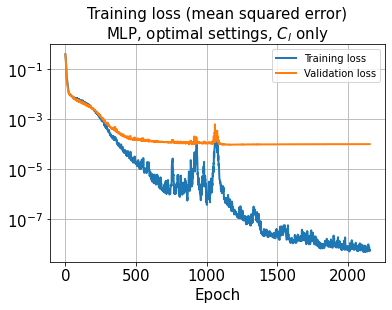

In [45]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

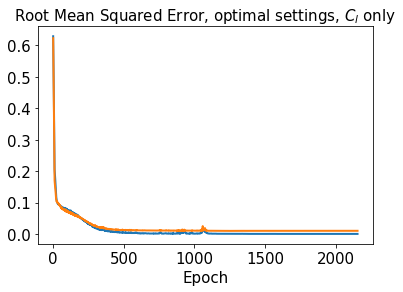

In [46]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

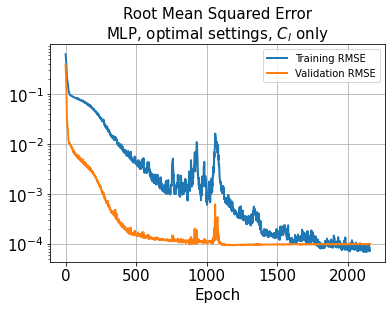

In [47]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [48]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 6.6312e-07 - rmse: 8.1432e-04


In [49]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 5.3435e-05 - rmse: 0.0073


In [87]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 14ms/step


In [88]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [89]:
y_train = y_train*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_val = y_val*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_test = y_test*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [90]:
decoded_train = decoded_train_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_val = decoded_val_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_test = decoded_test_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [54]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221130steadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [55]:
error_train_abs = np.abs(decoded_train - y_train)

In [56]:
error_val_abs = np.abs(decoded_val - y_val)

In [57]:
error_test_abs = np.abs(decoded_test - y_test)

In [58]:
os.chdir(storage_dir)

In [59]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0012443460325499286


In [60]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.012824080134894014


In [61]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.010934804211194247


In [62]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum((y_train[i]+1e-07)**2))
    l2_error_train_list.append(l2_error_train_data)

In [63]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [64]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum((y_test[i]+1e-07)**2))
    l2_error_test_list.append(l2_error_test_data)

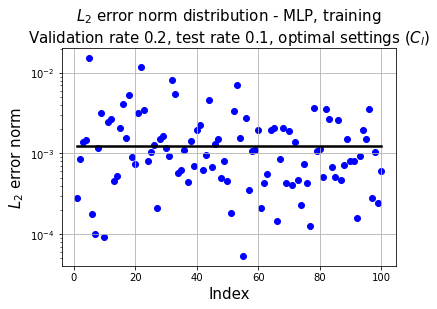

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

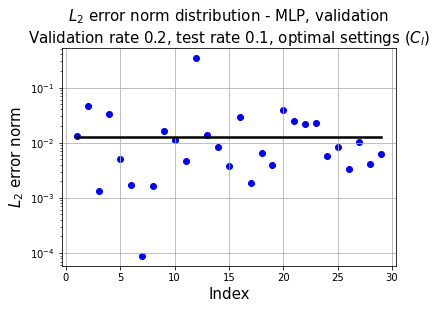

In [66]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

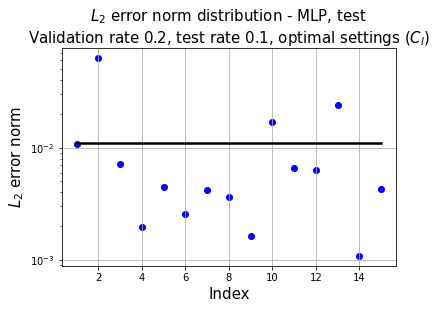

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [68]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [93]:
index_test

array([  5,  14,  16,  33,  42,  48,  53,  69,  74,  84,  91,  94, 108,
       112, 128], dtype=int64)

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for i, index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [99]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    '''# CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aVal, iVal*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='g', label='Validation set')
    plt.scatter(aTest, iTest*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

   # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 14ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0171


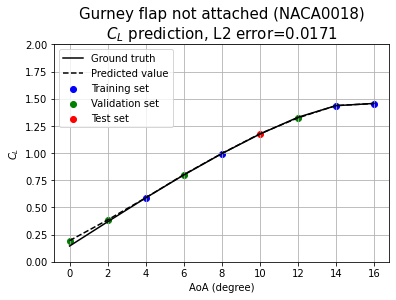

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0040


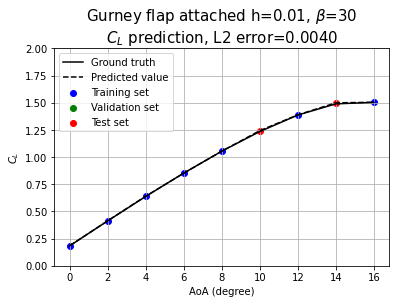

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0017


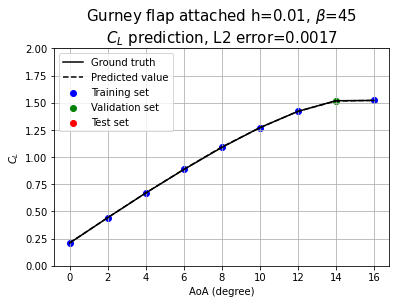

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0034


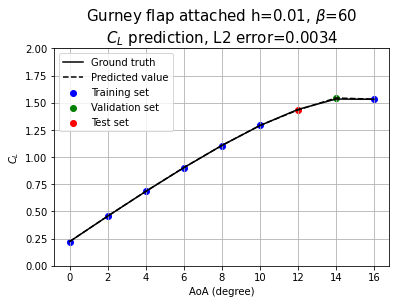

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0024


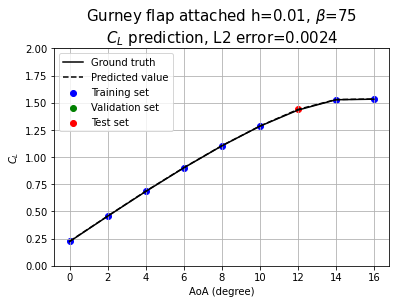

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0041


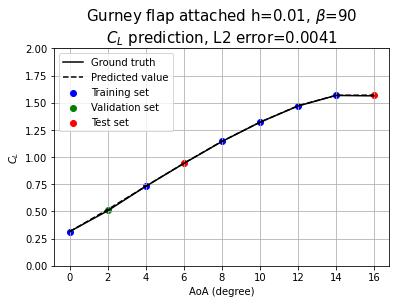

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0024


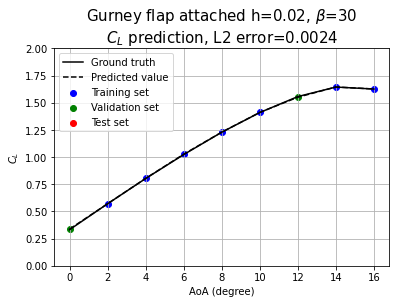

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0050


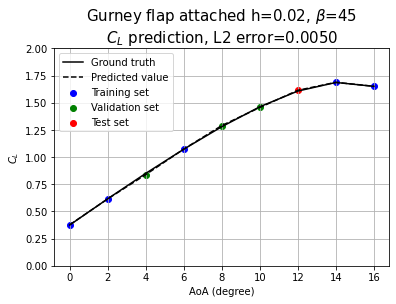

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0076


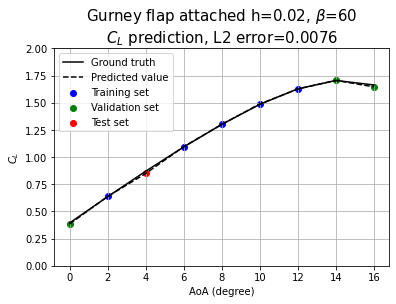

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0037


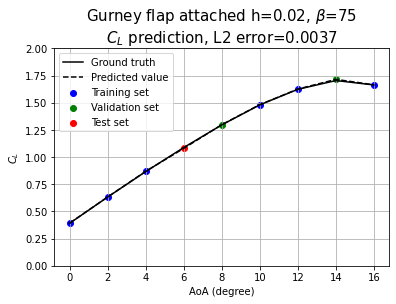

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0138


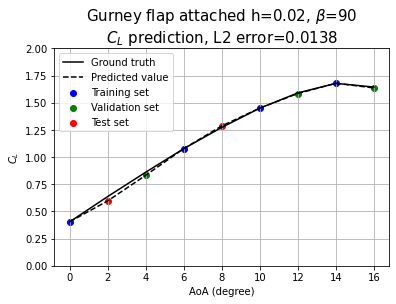

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0039


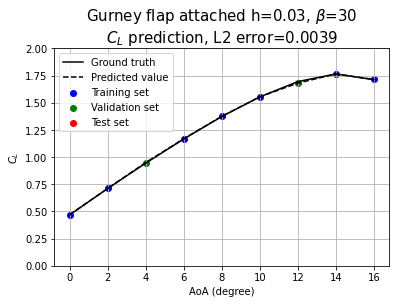

1/1 [==============================] - 0s 14ms/step
L2 error of Cl: 0.0035


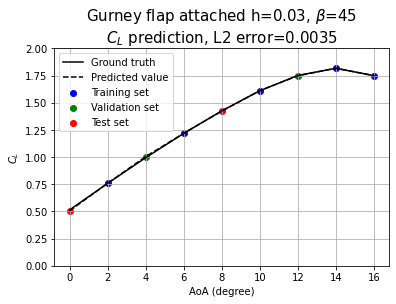

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0056


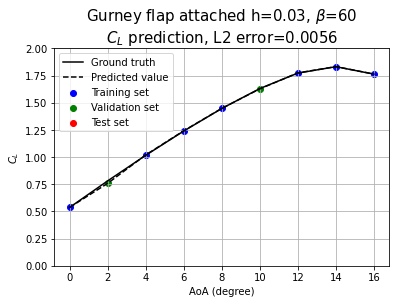

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0040


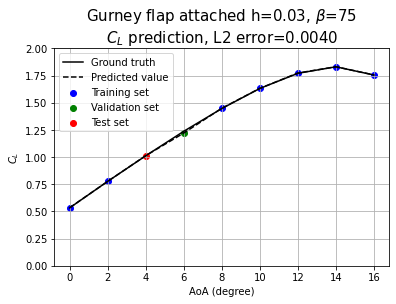

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0170


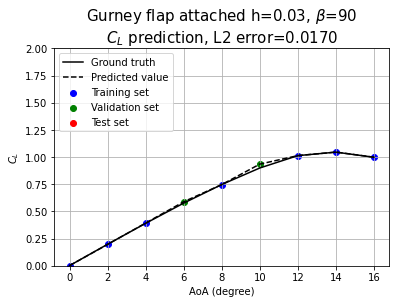

In [100]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iTest = np.array(iTest)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iVal = np.array(iVal)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)